In [1]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
warnings.filterwarnings('ignore')
# Loading the time series data with date parsing
data = pd.read_csv('./northern Taiwan/2015_Air_quality_in_northern_Taiwan.csv' ,parse_dates=['time'])



In [2]:
# Deleting the rows with NA in 'PM2.5', because we need to predict PM2.5
data = data[data['PM2.5'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215768 entries, 0 to 218639
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        215768 non-null  datetime64[ns]
 1   station     215768 non-null  object        
 2   AMB_TEMP    198538 non-null  object        
 3   CH4         95104 non-null   object        
 4   CO          215577 non-null  object        
 5   NMHC        94927 non-null   object        
 6   NO          215509 non-null  object        
 7   NO2         215102 non-null  object        
 8   NOx         215510 non-null  object        
 9   O3          198280 non-null  object        
 10  PH_RAIN     34202 non-null   object        
 11  PM10        215561 non-null  object        
 12  PM2.5       215768 non-null  object        
 13  RAINFALL    207268 non-null  object        
 14  RAIN_COND   34202 non-null   object        
 15  RH          198612 non-null  object        
 16  SO2    

In [3]:
data.drop(['UVB','RAIN_COND','PH_RAIN'],axis=1,inplace=True)
data = data.dropna(thresh=17) 

In [4]:
def numeric(row):
    try:
        if np.isnan(row):
            return
        else:
            row =str(row)
            return float(row.replace('x','').replace('#','').replace('*',''))
    except TypeError:
        row =str(row)
        return float(row.replace('x','').replace('#','').replace('*',''))

In [5]:
data['WS_HR'] = data['WS_HR'].apply(numeric)
print(data['WS_HR'].describe())
print('\nThe skewness:',data['WS_HR'].skew())
print('Right skewed') if data['WS_HR'].skew()>0 else print('Left skewed')

count    180128.000000
mean          1.987993
std           1.726888
min           0.000000
25%           0.800000
50%           1.500000
75%           2.700000
max          50.000000
Name: WS_HR, dtype: float64

The skewness: 4.005978883220031
Right skewed


In [6]:
data['WS_HR'].fillna(value=data['WS_HR'].median(),inplace=True)

In [7]:
for col in ['NO2','NO','NOx','PM10','CO','O3','AMB_TEMP','SO2','WD_HR','RH','WIND_DIREC', 'WIND_SPEED','PM2.5']:
    data[col]=data[col].apply(numeric)
    data[col].fillna(value=data[col].median(),inplace=True)
data['RAINFALL'] = data['RAINFALL'].apply(lambda x:0 if x=='NR' else x).apply(numeric)

In [8]:
data['PM2.5']

0         78.0
1         77.0
2         72.0
3         65.0
4         56.0
          ... 
218635    72.0
218636    79.0
218637    71.0
218638    76.0
218639    76.0
Name: PM2.5, Length: 180129, dtype: float64

In [9]:
print((data['CH4'].notna() & data['NMHC'].notna() & data['THC'].isna()).value_counts())
print('\n')
print(data['THC'].apply(numeric).describe())
print('\nMode :',data['THC'].apply(numeric).mode())
print('\nKurtosis is ',data['THC'].apply(numeric).kurt(),'>3, it is leptokurtic')

False    180129
Name: count, dtype: int64


count    77803.000000
mean         2.121760
std          0.341647
min         -0.300000
25%          1.900000
50%          2.100000
75%          2.200000
max         20.000000
Name: THC, dtype: float64

Mode : 0    2.0
Name: THC, dtype: float64

Kurtosis is  109.04199317121108 >3, it is leptokurtic


In [10]:
data.drop(['CH4','NMHC','THC'],axis=1,inplace=True)

In [11]:
data['year'] = pd.to_datetime(data['time']).dt.year
data['month'] = pd.to_datetime(data['time']).dt.month
data['day'] = pd.to_datetime(data['time']).dt.day
data['hour'] = pd.to_datetime(data['time']).dt.hour

In [12]:
# Assume 'target_variable' is the column and we need to predict that column
target_col ='PM2.5'

# Sorting the DataFrame by the time column 
data = data.sort_values(by='month')



In [13]:
data

,time,station,AMB_TEMP,CO,NO,NO2,NOx,O3,PM10,PM2.5,...,RH,SO2,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,year,month,day,hour
0,2015-01-01 00:00:00,Banqiao,16.0,0.79,1.2,16.0,17.0,37.0,177.0,78.0,...,57.0,12.0,69.0,69.0,4.7,4.2,2015,1,1,0
96378,2015-01-08 18:00:00,Shilin,14.0,0.44,2.6,13.0,16.0,33.0,76.0,39.0,...,59.0,3.5,106.0,113.0,2.6,2.4,2015,1,8,18
96379,2015-01-08 19:00:00,Shilin,14.0,0.42,1.8,12.0,14.0,33.0,76.0,35.0,...,58.0,3.4,109.0,110.0,2.2,2.3,2015,1,8,19
96380,2015-01-08 20:00:00,Shilin,14.0,0.48,2.7,16.0,19.0,27.0,70.0,29.0,...,60.0,4.0,114.0,114.0,2.0,1.9,2015,1,8,20
96381,2015-01-08 21:00:00,Shilin,14.0,0.45,2.3,16.0,18.0,28.0,70.0,26.0,...,61.0,3.9,113.0,111.0,2.0,1.9,2015,1,8,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51837,2015-12-02 21:00:00,Guting,22.0,0.50,2.6,20.0,23.0,25.0,37.0,12.0,...,82.0,1.8,83.0,81.0,2.3,2.1,2015,12,2,21
51838,2015-12-02 22:00:00,Guting,21.0,0.55,2.8,19.0,22.0,22.0,39.0,16.0,...,84.0,2.0,85.0,66.0,2.1,2.1,2015,12,2,22
51839,2015-12-02 23:00:00,Guting,21.0,0.49,2.2,15.0,17.0,21.0,53.0,18.0,...,84.0,1.9,83.0,92.0,2.8,2.1,2015,12,2,23
51829,2015-12-02 13:00:00,Guting,24.0,0.34,2.7,12.0,14.0,40.0,25.0,13.0,...,74.0,1.6,315.0,316.0,3.1,2.8,2015,12,2,13


In [14]:
# Extract features (X) and target variable (y)
X = data.drop(target_col, axis=1)
y = data[target_col]


In [15]:
# Dropping of timestamp column
X = X.drop('time', axis=1)



In [134]:
# train, test, and validation sets of the data
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)



In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180129 entries, 0 to 218639
Data columns (total 19 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   station     180129 non-null  int64  
 1   AMB_TEMP    180129 non-null  float64
 2   CO          180129 non-null  float64
 3   NO          180129 non-null  float64
 4   NO2         180129 non-null  float64
 5   NOx         180129 non-null  float64
 6   O3          180129 non-null  float64
 7   PM10        180129 non-null  float64
 8   RAINFALL    180129 non-null  float64
 9   RH          180129 non-null  float64
 10  SO2         180129 non-null  float64
 11  WD_HR       180129 non-null  float64
 12  WIND_DIREC  180129 non-null  float64
 13  WIND_SPEED  180129 non-null  float64
 14  WS_HR       180129 non-null  float64
 15  year        180129 non-null  int32  
 16  month       180129 non-null  int32  
 17  day         180129 non-null  int32  
 18  hour        180129 non-null  int32  
dtypes: floa

In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X['station'] = label_encoder.fit_transform(X['station'])


In [32]:
X

,station,AMB_TEMP,CO,NO,NO2,NOx,O3,PM10,RAINFALL,RH,SO2,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,year,month,day,hour
0,0,16.0,0.79,1.2,16.0,17.0,37.0,177.0,0.0,57.0,12.0,69.0,69.0,4.7,4.2,2015,1,1,0
96378,9,14.0,0.44,2.6,13.0,16.0,33.0,76.0,0.0,59.0,3.5,106.0,113.0,2.6,2.4,2015,1,8,18
96379,9,14.0,0.42,1.8,12.0,14.0,33.0,76.0,0.0,58.0,3.4,109.0,110.0,2.2,2.3,2015,1,8,19
96380,9,14.0,0.48,2.7,16.0,19.0,27.0,70.0,0.0,60.0,4.0,114.0,114.0,2.0,1.9,2015,1,8,20
96381,9,14.0,0.45,2.3,16.0,18.0,28.0,70.0,0.0,61.0,3.9,113.0,111.0,2.0,1.9,2015,1,8,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51837,4,22.0,0.50,2.6,20.0,23.0,25.0,37.0,0.0,82.0,1.8,83.0,81.0,2.3,2.1,2015,12,2,21
51838,4,21.0,0.55,2.8,19.0,22.0,22.0,39.0,0.0,84.0,2.0,85.0,66.0,2.1,2.1,2015,12,2,22
51839,4,21.0,0.49,2.2,15.0,17.0,21.0,53.0,0.0,84.0,1.9,83.0,92.0,2.8,2.1,2015,12,2,23
51829,4,24.0,0.34,2.7,12.0,14.0,40.0,25.0,0.0,74.0,1.6,315.0,316.0,3.1,2.8,2015,12,2,13


In [33]:
X_train

,station,AMB_TEMP,CO,NO,NO2,NOx,O3,PM10,RAINFALL,RH,SO2,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,year,month,day,hour
0,0,16.0,0.79,1.2,16.0,17.0,37.0,177.0,0.0,57.0,12.0,69.0,69.0,4.7,4.2,2015,1,1,0
96378,9,14.0,0.44,2.6,13.0,16.0,33.0,76.0,0.0,59.0,3.5,106.0,113.0,2.6,2.4,2015,1,8,18
96379,9,14.0,0.42,1.8,12.0,14.0,33.0,76.0,0.0,58.0,3.4,109.0,110.0,2.2,2.3,2015,1,8,19
96380,9,14.0,0.48,2.7,16.0,19.0,27.0,70.0,0.0,60.0,4.0,114.0,114.0,2.0,1.9,2015,1,8,20
96381,9,14.0,0.45,2.3,16.0,18.0,28.0,70.0,0.0,61.0,3.9,113.0,111.0,2.0,1.9,2015,1,8,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66476,6,26.0,0.21,6.7,9.2,16.0,5.7,17.0,7.8,95.0,1.3,119.0,113.0,1.7,1.6,2015,8,6,20
66474,6,29.0,0.13,3.6,4.8,8.4,11.0,26.0,0.0,78.0,1.4,49.0,48.0,3.7,4.1,2015,8,6,18
66445,6,30.0,0.19,0.7,3.9,4.6,82.0,55.0,0.0,75.0,2.6,307.0,311.0,3.9,2.1,2015,8,5,13
66443,6,29.0,0.11,1.2,3.9,5.1,57.0,48.0,0.0,76.0,2.1,302.0,308.0,3.5,1.9,2015,8,5,11


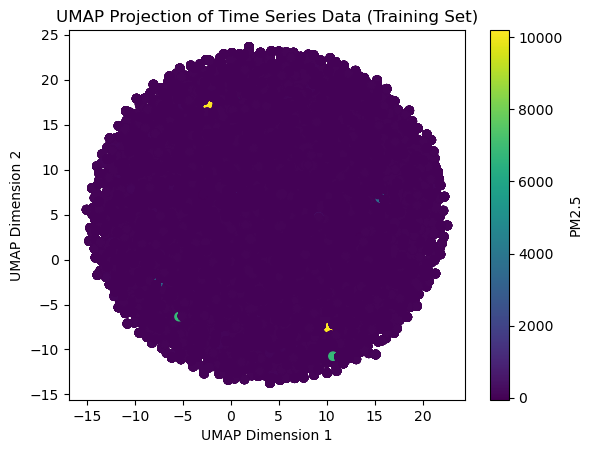

In [37]:
# Reduction of UMAP dimensionality on training data
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_result_train = umap_model.fit_transform(X_train)

# Plot the UMAP
plt.scatter(umap_result_train[:, 0], umap_result_train[:, 1], c=y_train, cmap='viridis')
plt.title('UMAP Projection of Time Series Data (Training Set)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label=target_col)
plt.show()

In [86]:


import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Define the RandomForestRegressor model
rf_model = RandomForestRegressor()
# Fit the model
rf_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_model.predict(X_test)
          


In [39]:
#Evaluate the Random Forest Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')



Mean Absolute Error: 11.511744018209072
Mean Squared Error: 3293.885428809748
Root Mean Squared Error: 57.39238127843929
R-squared: -1.3218973265195642


In [46]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
tscv = TimeSeriesSplit(n_splits=3)

In [34]:
# Hyperparameter tuning using RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf_model_tuned = RandomForestRegressor()


random_search = RandomizedSearchCV(
    rf_model_tuned,
    param_distributions=param_grid,
    n_iter=10,  
    scoring='neg_mean_squared_error',  
    cv=tscv,  
    verbose=1,
    n_jobs=-1,  
    random_state=42
)


random_search.fit(X_train, y_train)


best_params = random_search.best_params_
print(f'Best Hyperparameters: {best_params}')


y_pred_tuned = random_search.predict(X_test)


mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f'Tuned Model Metrics:')
print(f'Mean Absolute Error: {mae_tuned}')
print(f'Mean Squared Error: {mse_tuned}')
print(f'Root Mean Squared Error: {rmse_tuned}')
print(f'R-squared: {r2_tuned}')

In [46]:
X_train.shape

(108077, 19)

In [47]:
y_train.shape

(108077,)

In [89]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Reshaping the X_train  into (108077, 1, 19)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu',return_sequences = True, input_shape=(1, X_train.shape[1])))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))  # Assuming you're predicting a single value

# Compilation of the model
model.compile(optimizer='adam', loss='mse')

# Training of the model
model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32)


Epoch 1/30
3378/3378 [==============================] - 8s 2ms/step - loss: 6316.6421
Epoch 2/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6263.8447
Epoch 3/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6252.6206
Epoch 4/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6254.8726
Epoch 5/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6243.5576
Epoch 6/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6246.6216
Epoch 7/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6245.7124
Epoch 8/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6239.8169
Epoch 9/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6248.0762
Epoch 10/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6242.3149
Epoch 11/30
3378/3378 [==============================] - 6s 2ms/step - loss: 6243.0347
Epoch 12/30
3378/3378 [=============================

In [90]:
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_pred = model.predict(X_test_reshaped)

1126/1126 [==============================] - 1s 997us/step


In [91]:
y_test_array = y_test.values
type(y_test_array)
y_test_array

array([27., 24., 22., ..., 16., 13., 25.])

In [92]:
type(y_pred)
y_pred_flatten = y_pred.flatten()

In [93]:
y_pred_flatten

array([26.054905, 23.778975, 22.538385, ..., 15.081231, 19.803478,
       39.90417 ], dtype=float32)

In [111]:
#Evaluate the LSTM model
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

mse = mean_squared_error(y_test_array, y_pred_flatten)
print(f'Mean Squared Error: {mse}')
mae = mean_absolute_error(y_test_array, y_pred_flatten)
print(f'Mean abs Error: {mae}')




Mean Squared Error: 2496.2159682598417
Mean abs Error: 8.315673153134577


In [95]:

y_pred_int = np.round(y_pred_flatten).astype(int)

# Calculation of accuracy, F1-score, and confusion matrix
accuracy = accuracy_score(y_test_array, y_pred_int)
f1 = f1_score(y_test_array, y_pred_int, average='weighted')
conf_matrix = confusion_matrix(y_test_array, y_pred_int)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 6.32%
F1-Score: 0.0585
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [102]:
# Fit ARIMA model
order = (1, 1, 0)  
endog_column = X_train.iloc[:, 0]
model = ARIMA(endog_column, order=order)
model_fit = model.fit()

C:\Users\91889\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91889\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91889\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [104]:
predictions = model_fit.forecast(steps=len(X_test))

C:\Users\91889\miniconda3\envs\ml\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [105]:
predictions

108077    6.0
108078    6.0
108079    6.0
108080    6.0
108081    6.0
         ... 
144098    6.0
144099    6.0
144100    6.0
144101    6.0
144102    6.0
Name: predicted_mean, Length: 36026, dtype: float64

Mean Squared Error: 1537.0233164936435
Mean Squared Error: 11.768389496474768


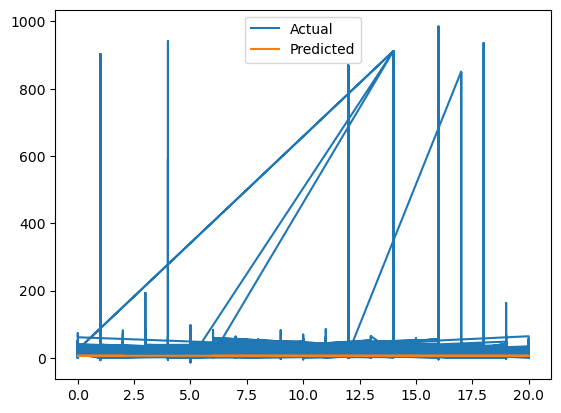

In [109]:
# Evaluate the ARIMA model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
mae = mean_absolute_error(y_test, predictions)
print(f'Mean abs Error: {mae}')
# Plot actual vs predicted values
plt.plot(X_test.iloc[:, 0], y_test, label='Actual')
plt.plot(X_test.iloc[:, 0], predictions, label='Predicted')
plt.legend()
plt.show()